Ссылка на данные: https://drive.google.com/drive/folders/1Nm1XbW95qb-5AGv4yIvAkCuAQC9CXiOc?usp=sharing

In [ ]:
!gdown 1hB36sReQ0PgOEy1ie0uTs0NHEKY8F1e1
!gdown 1rZLZQfpUsPIh3nMl3GbOfqJDsjhtEG1i

Downloading...
From (original): https://drive.google.com/uc?id=1hB36sReQ0PgOEy1ie0uTs0NHEKY8F1e1
From (redirected): https://drive.google.com/uc?id=1hB36sReQ0PgOEy1ie0uTs0NHEKY8F1e1&confirm=t&uuid=7d00c5af-fe14-48df-9672-d428435b17c0
To: /content/train.csv
100% 241M/241M [00:06<00:00, 34.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rZLZQfpUsPIh3nMl3GbOfqJDsjhtEG1i
To: /content/test.csv
100% 60.1M/60.1M [00:01<00:00, 48.1MB/s]


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import pandas as pd
from tqdm import tqdm_notebook
import cv2
from IPython.display import clear_output

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
N_CLASSES = len(EMOTIONS)

In [ ]:
# каждое изображение растянуто в строку в таблице
# преобразуем в привычный массив, не создавая папки с изображениями явным образом,
# т.к. метод .fit() работает гораздо быстрее чем .fit_generator()
# для контроля переобучения выделите из X_train, y_train данные для валидации

img_width, img_height = (48,48)

def str_to_image(image_blob):
    image_string = image_blob[0].split(' ')
    image_data = np.asarray(image_string, dtype=np.uint8).reshape(48,48)
    return image_data

def csv_to_array(csv):
    X = csv.pixels.values
    X = np.apply_along_axis(str_to_image, 1, X[:,None])/255.
    X = X[:, None, :, :]
    return X

train = pd.read_csv('train.csv') # для обучения и валидации
test = pd.read_csv('test.csv') # для сабмита на кагл

y_train = train.emotion.values
X_train = csv_to_array(train)
X_test= csv_to_array(test)

# X_val, y_val = ... # Ваш код здесь

In [ ]:
X_train.shape, y_train.shape

((28709, 1, 48, 48), (28709,))

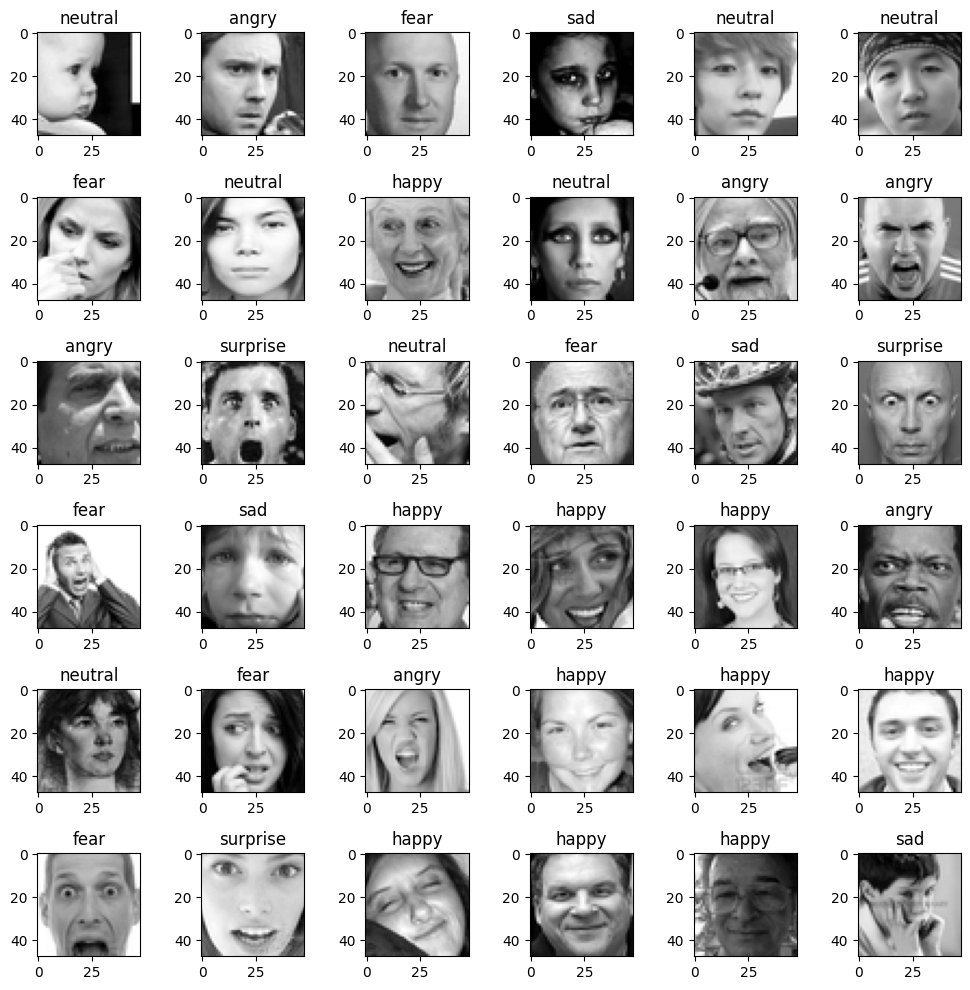

In [ ]:
# посмотрим как выглядят изображения
N_IMAGES_TO_PLOT = 36
fig, axes = plt.subplots(nrows=np.sqrt(N_IMAGES_TO_PLOT).astype(int),
                         ncols = np.sqrt(N_IMAGES_TO_PLOT).astype(int),
                         figsize=(10,10))

rand_indx = np.random.choice(np.arange(N_IMAGES_TO_PLOT), size=N_IMAGES_TO_PLOT, replace=False)
for ax, emotion_index, img in zip(axes.flatten(), train.emotion.values[rand_indx], X_train[rand_indx]):
    img = img[0,:,:] # [1, 48,48] -> [48,48]
    ax.imshow(img, cmap='gray')
    emotion = EMOTIONS[emotion_index]
    ax.set_title(emotion)
plt.tight_layout()
plt.show()

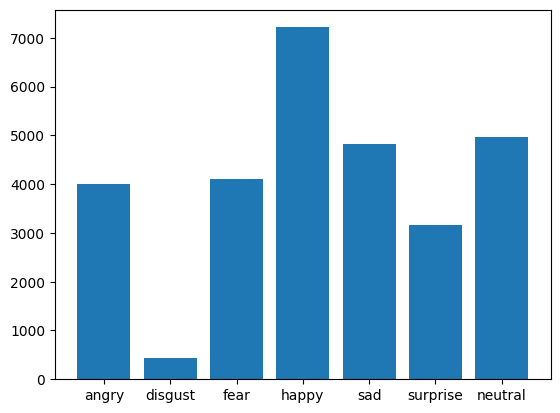

In [ ]:
# посмотрим насколько сбалансированны классы в обучающей выборке
train_count = train.groupby('emotion').count()
plt.bar(x = EMOTIONS,
        height=train_count.values.flatten())
plt.show()

Виден сильный дисбаланс между классом `disguist` и остальными

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

Создаем класс датасета и даталоадера для нашей обучающей выборки

In [ ]:

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

X_test_tensor = torch.Tensor(X_test)

Базовая модель:

In [ ]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(3200, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, N_CLASSES),
).to(device)

Функции для обучения:

In [ ]:
# Функция обучения одной эпохи
def train_step(model, train_dataloader, optimizer, criterion):

    model.train() # Переводим модель в режим тренировки

    # Сохраняем различные статистики внутри эпохи
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Итерация по батчам в датасете
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        # Перемещение данных на GPU
        labels = labels.type(torch.LongTensor)
        inputs, labels = inputs.to(device), labels.to(device)

        # Обнуление градиентов.
        # Без данной строчки, торч просто добавит их к предыдущим
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs) # Передаем изображения в модель
        loss = criterion(outputs, labels) # Считаем функцию потерь
        loss.backward() # Применяем обратное распространение ошибки
        optimizer.step() # Делаем шаг обучения

        # Статистика для вывода
        running_loss += loss.item()
        predicted = torch.argmax(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Вычисление среднего значения потерь и точности на эпохе
    train_accuracy = correct_predictions / total_samples
    average_loss = running_loss / len(train_dataloader)

    return average_loss, train_accuracy

# общая функция ддя обучения
def train_model(model, train_dataloader, optimizer, criterion, num_epochs=8):
    #Будем складывать accuracy на каждой эпохе
    train_accuracy_history = []
    train_loss_history = []

    for epoch in range(num_epochs): # Итерируемся по эпохам
        # шаг обучения
        average_loss, train_accuracy = train_step(model, train_dataloader, optimizer, criterion)
        train_accuracy_history.append(train_accuracy)
        train_loss_history.append(average_loss)

        # Вывод результатов
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Loss: {average_loss:.4f} | Train Accuracy: {train_accuracy:.4f}')

    return train_accuracy_history, train_loss_history

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train_accuracy_history, train_loss_history = train_model(model,train_dataloader, optimizer, criterion, 25)

Epoch 2/25
Loss: 1.5635 | Train Accuracy: 0.3923
Epoch 3/25
Loss: 1.4736 | Train Accuracy: 0.4330
Epoch 4/25
Loss: 1.4004 | Train Accuracy: 0.4630
Epoch 5/25
Loss: 1.3388 | Train Accuracy: 0.4846
Epoch 6/25
Loss: 1.2848 | Train Accuracy: 0.5067
Epoch 7/25
Loss: 1.2326 | Train Accuracy: 0.5306
Epoch 8/25
Loss: 1.1837 | Train Accuracy: 0.5512
Epoch 9/25
Loss: 1.1412 | Train Accuracy: 0.5712
Epoch 10/25
Loss: 1.0996 | Train Accuracy: 0.5831
Epoch 11/25
Loss: 1.0482 | Train Accuracy: 0.6074
Epoch 12/25
Loss: 1.0068 | Train Accuracy: 0.6227
Epoch 13/25
Loss: 0.9579 | Train Accuracy: 0.6433
Epoch 14/25
Loss: 0.9180 | Train Accuracy: 0.6561
Epoch 15/25
Loss: 0.8678 | Train Accuracy: 0.6752
Epoch 16/25
Loss: 0.8269 | Train Accuracy: 0.6916
Epoch 17/25
Loss: 0.7831 | Train Accuracy: 0.7099
Epoch 18/25
Loss: 0.7376 | Train Accuracy: 0.7258
Epoch 19/25
Loss: 0.6951 | Train Accuracy: 0.7420
Epoch 20/25
Loss: 0.6578 | Train Accuracy: 0.7557
Epoch 21/25
Loss: 0.6131 | Train Accuracy: 0.7740
Epoch 22

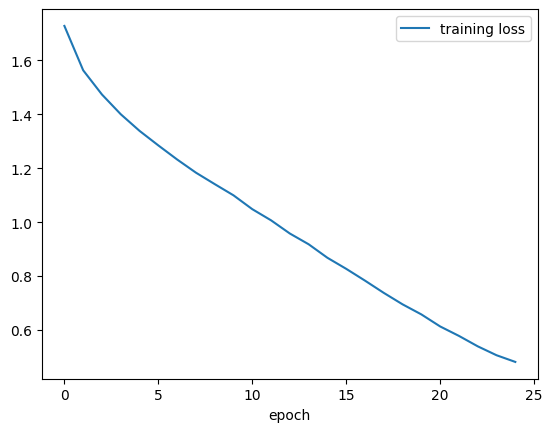

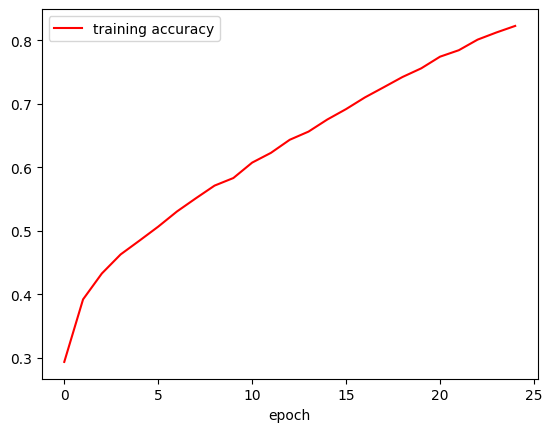

In [ ]:
plt.figure()
plt.plot(train_loss_history, label='training loss')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(train_accuracy_history, color='r', label='training accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Как сделать лучше?

 - Начните со сверточной нейронной сети: Conv2D -> Activation ReLU -> Conv2D ... -> Dense
 - Transfer Learning: взять предобученную на большом датасете модель и слегка дообучить ее, подстроив под новую задачу. Это возможно, т.к. большая часть слоев нейронной сети, обученной для классификации изображений, извлекает признаки из изображения, а последний, линейный слой, выступает в роли классификатора. Подробнее - [здесь](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
 - Аугментация данных: небольшой размер датасета и большое количество параметров модели (что характерно для нейронных сетей) способствует переобучению. Проблему недостатка данных можно решить трансформацией батча на этапе обучения, например, вращая изображения или меняя уровень яркости. Подробнее - [здесь](https://topminisite.com/blog/how-to-apply-data-augmentation-to-images-in-pytorch)  
 - Попробуйте убрать дисбаланс в данных, использовав простой oversampling: например для каждого класса добавьте в него случайно выбранные из него-же данные.

In [ ]:
# вычисляет и скачивает файл для submission на kaggle
def submit(model, X_test):
    with torch.no_grad():
        model.eval()
        prediction=model(X_test.to(device))

        pred_classes = prediction.cpu().argmax(-1)
        df = pd.DataFrame(data = {'Id':np.arange(len(pred_classes)),
                                  'Category':pred_classes})

        df.to_csv('submission.csv', index=False)
        files.download('submission.csv')

submit(model, X_test_tensor)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>